In [1]:
from google.colab import drive
import torch

drive.mount('mount/')
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

Mounted at mount/
cpu


In [2]:
from torch.utils.data import Dataset
import os

class AudioMNIST(Dataset):
  def __init__(self, wav, mask):
    self.wav = wav # wave path
    self.mask = mask # mask path
    self.len = len(os.listdir(self.wav))

  def __getitem__(self, index):
    ls_wav = sorted(os.listdir(self.wav))
    ls_mask = sorted(os.listdir(self.mask))

    wav_file_path = os.path.join(self.wav, ls_wav[index])
    wav_tensor = torch.load(wav_file_path)

    mask_file_path = os.path.join(self.mask, ls_mask[index])
    mask_tensor = torch.load(mask_file_path)

    return wav_tensor, mask_tensor

  def __len__(self):
    return self.len  

test = AudioMNIST('mount/MyDrive/audiomnist/test/wav/', 'mount/MyDrive/audiomnist/test/mask/')

In [3]:
import random
import torch.nn.functional as F

batch_size = 8

testdataloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

torch.Size([17, 13, 1])


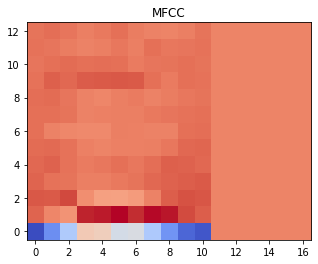

7


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

fig, ax = plt.subplots()
print(test[0][0].size())
mfcc_data= np.swapaxes(test[0][0].squeeze().numpy(), 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
ax.set_title('MFCC')
plt.show()
print(test[0][1])

In [7]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = torch.nn.Embedding(input_size, self.hidden_size)
        self.gru = torch.nn.GRU(input_size, self.hidden_size, batch_first=True, bidirectional=True)
        self.lin = torch.nn.Sequential(torch.nn.Linear(2*self.hidden_size, int(0.25*self.hidden_size)),
                                    torch.nn.LeakyReLU(0.2, inplace=False),
                                    torch.nn.Linear(int(0.25*self.hidden_size), int(0.0625*self.hidden_size)),
                                    torch.nn.LeakyReLU(0.2, inplace=False),
                                    torch.nn.Linear(int(0.0625*self.hidden_size), 10))

    def forward(self, input):
        latent, hidden = self.gru(input)
        latent = latent[:, -1, :]
        output = self.lin(latent)
        return output

hidden_size = 128
n_mfcc = 13

encoder = Encoder(n_mfcc, hidden_size).to(device)
encoder.load_state_dict(torch.load('mount/MyDrive/encoder.pt', map_location=device))

<All keys matched successfully>

In [8]:
# channel
nc = 1
# latent vector
nz = 128
# generator feature maps
ngf = 64
# discriminator feature map
ndf = 64
# gpu
ngpu = 1
# class
n_classes = 10

In [9]:
class Generator(torch.nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.label_cg = torch.nn.Sequential(torch.nn.Embedding(n_classes, 100),
                      torch.nn.Linear(100, 16))  

        self.latent = torch.nn.Sequential(torch.nn.Linear(nz, 1*1*1024),
                                    torch.nn.LeakyReLU(0.2, inplace=False))

        self.main = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(1040, ngf * 8, 4, 1, 0, bias=False), # 4, 4
            torch.nn.BatchNorm2d(ngf * 8),
            torch.nn.LeakyReLU(0.2, inplace=False),
            torch.nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False), # 8, 8
            torch.nn.BatchNorm2d(ngf * 4),
            torch.nn.LeakyReLU(0.2, inplace=False),
            torch.nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False), # 16, 16
            torch.nn.BatchNorm2d(ngf * 2),
            torch.nn.LeakyReLU(0.2, inplace=False),
            torch.nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False), # 32, 32
            torch.nn.BatchNorm2d(ngf),
            torch.nn.LeakyReLU(0.2, inplace=False),
            torch.nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False), # 64, 64
            torch.nn.Tanh()
        )

    def forward(self, latent, label):
        label = self.label_cg(label)
        label = label.view(-1, 16, 1, 1)
        latent = self.latent(latent)
        latent = latent.view(-1, 1024, 1, 1)
        concat = torch.cat((latent, label), dim=1)
        return self.main(concat)

#if (device.type == 'cuda') and (ngpu > 1):
    #netG = nn.DataParallel(netG, list(range(ngpu)))

netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load('mount/MyDrive/gen.pt', map_location=device))

<All keys matched successfully>

In [10]:
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np

def plot(img):
    plt.style.use('dark_background')
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("fake images")
    plt.imshow(np.transpose(img.cpu(),(1,2,0)))
    plt.show()

predicted class:  tensor([8, 5, 9, 4, 0, 5, 2, 1]) 
label:  tensor([8, 5, 9, 4, 0, 5, 2, 1])


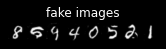

In [21]:
wav, tag = next(iter(testdataloader))
noise = torch.randn(8, nz).to(device)
pred = encoder(wav.squeeze())
fake = netG(noise, torch.argmax(pred, dim=1))
print("predicted class: ", torch.argmax(pred, dim=1), "\nlabel: ", tag)
plot(tv.utils.make_grid(fake[:8], padding=2, normalize=True).cpu())